# 02450 Project 2


The primary goal of Project 2 is to apply supervised learning techniques (regression and classification) to predict properties or classifications of wood based on the cleaned and scaled dataset from Project 1.

In [17]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm
import xlrd
import scipy
from scipy.linalg import svd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import (
    figure,
    grid,
    legend,
    loglog,
    plot,
    semilogx,
    show,
    subplot,
    title,
    xlabel,
    ylabel,
)

import sklearn.linear_model as lm
from matplotlib.pylab import figure, hist, plot, show, subplot, xlabel, ylabel
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from dtuimldmtools import *
from dtuimldmtools.statistics.statistics import correlated_ttest
from dtuimldmtools import confmatplot, rocplot
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Cleaned and Scaled Data from Project 1

Hardwood= 1, Softwood = 0

In [18]:
cwd = os.getcwd()
data = pd.read_csv(cwd + '/usa_wood_data_formatted.csv')

removed_columns = ['side_hardness','tension_perpendicular_to_grain','impact_bending']
data_cleaned = data.drop(columns=removed_columns)
data_cleaned = data_cleaned.dropna()
print(data_cleaned.isnull().sum()) # 0 means data is clean

data_arr = np.array(data_cleaned)  # Attributes are columns
attributeNames = [name for name in data_cleaned.columns]
attributeNames = attributeNames[7:12]
attributeNames = np.concatenate((['Wood Type', 'Moisture Content'], attributeNames))
print(attributeNames)

for i in range(data_arr.shape[1]):
    val, count = np.unique(data_arr[:,i], return_counts=True)
    #print(val.shape)        # Print how many unique values of each attribute exist 
                            # Probably dont do one of k coding for first 4 attributes since they have so many unique values

data_adj = data_arr[:,6:13]
print("1",data_adj.shape)

for i in range(2):
    OoK = np.zeros([data_arr.shape[0], 1])
    val, count = np.unique(data_arr[:,5 - i], return_counts=True)
    
    for j in range(data_arr.shape[0]):
        if data_arr[j,5-i] == val[0]:
            OoK[j, 0] = 1
    data_adj = np.concatenate((OoK, data_adj), 1)
print("2",data_adj.shape)


#classsification
y = data_adj[:,0]
X = data_adj[:,1:9]
#X = np.concatenate(data_adj[:,2:9], 1)
#regression
#y = data_adj[:,4]
# = np.concatenate((data_adj[:,0:3], data_adj[:,5:]), 1)
N, M = X.shape

X = X.astype(np.float32)  # Convert to float32 (or float64 if necessary)
y = y.astype(np.float32)  # Convert y to float32

#print(y)
print("X-shape", X.shape)


# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)  # Features as float32
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Target variable as float32 and reshaped to (N, 1)
#X_tensor = torch.FloatTensor(X)
#y_tensor = torch.FloatTensor(X_scaled[:,6])
#y_tensor = torch.FloatTensor(y).unsqueeze(1)


common_species_name                   0
genus                                 0
species                               0
scientific_name                       0
classification                        0
moisture_content                      0
specific_gravity                      0
modulus_of_rupture                    0
modulus_of_elasticity                 0
work_to_maximum_load                  0
compression_parallel_to_grain         0
compression_perpendicular_to_grain    0
shear_parallel_to_grain               0
dtype: int64
['Wood Type' 'Moisture Content' 'modulus_of_rupture'
 'modulus_of_elasticity' 'work_to_maximum_load'
 'compression_parallel_to_grain' 'compression_perpendicular_to_grain']
1 (214, 7)
2 (214, 9)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

###  Two-Level Cross-Validation Model

K1 = outer loop

K2 = inner loop

h = no. of hidden neurons



Tasks for Classification:

Logistic regression

Method 2
2) ANN
3) Classification tree
4) k-nearest neighbor classification
5) Na¨ıve Bayes

Baseline:
Compute largest class on the training data, and predict everything in the test-data as belonging to that class (corresponding to the optimal prediction by a logistic regression model with a bias
term and no features)

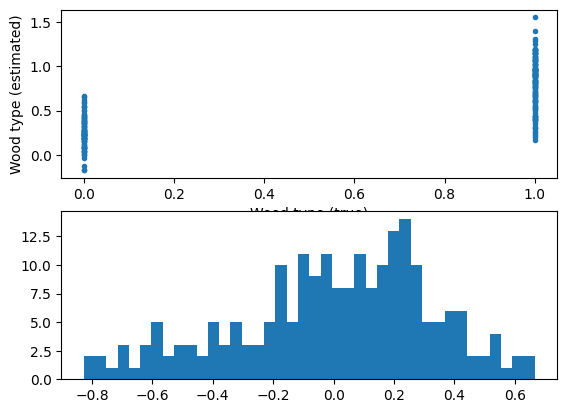

In [19]:
# Logistic regression
# Fit ordinary least squares regression model
model = lm.LinearRegression(fit_intercept=True)
model = model.fit(X, y)
# Compute model output:
y_est = model.predict(X)
residual = y_est - y

# Display scatter plot
figure()
subplot(2, 1, 1)
plot(y, y_est, ".")
xlabel("Wood type (true)")
ylabel("Wood type (estimated)")
subplot(2, 1, 2)
hist(residual, 40)

show()

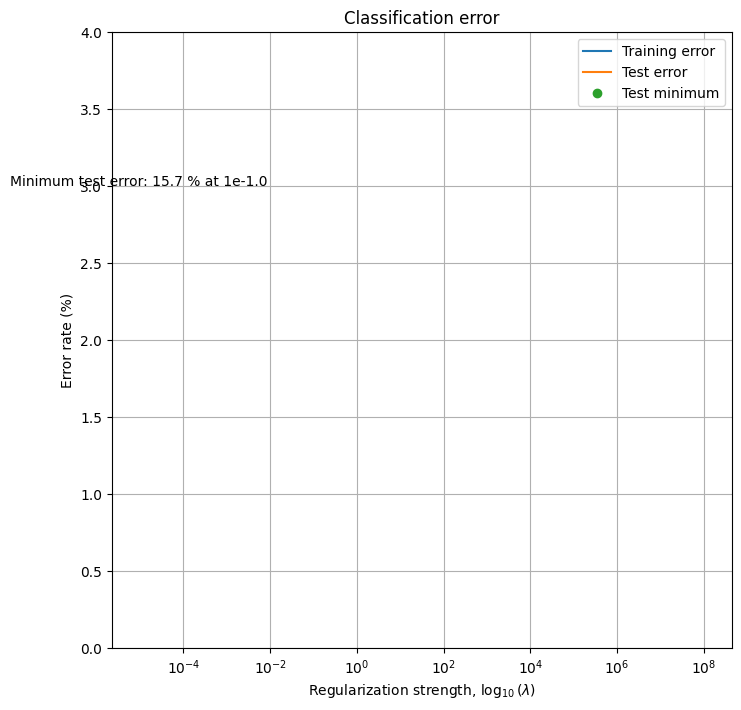

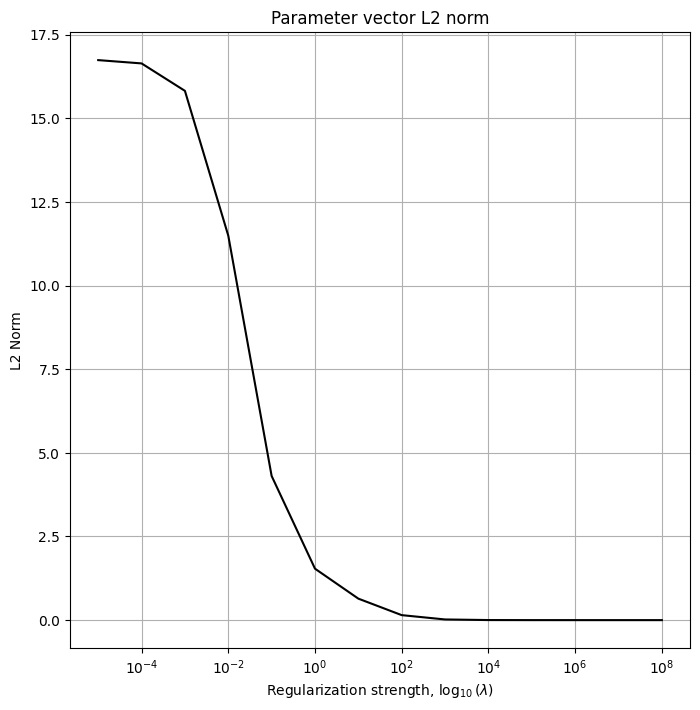

In [20]:
#Logistic regression model: Evaluating classification 

# Create crossvalidation partition for evaluation
# using stratification and 95 pct. split between training and test
K = 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, stratify=y)
# Try to change the test_size to e.g. 50 % and 99 % - how does that change the
# effect of regularization? How does differetn runs of  test_size=.99 compare
# to eachother?

# Standardize the training and set set based on training set mean and std
mu = np.mean(X_train, 0)
sigma = np.std(X_train, 0)

X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

# Fit regularized logistic regression model to training data to predict
# the type of wine
#lambda_interval = np.logspace(-8, 2, 50)
lambda_interval = np.power(10.0, range(-5, 9))
# Values of lambda from Part a
#lambdas = np.power(10.0, range(-5, 9))

train_error_rate = np.zeros(len(lambda_interval))
test_error_rate = np.zeros(len(lambda_interval))
coefficient_norm = np.zeros(len(lambda_interval))
for k in range(0, len(lambda_interval)):
    mdl = LogisticRegression(penalty="l2", C=1 / lambda_interval[k], max_iter=1000) #what exactly does Max Iter do?!

    mdl.fit(X_train, y_train)

    y_train_est = mdl.predict(X_train).T
    y_test_est = mdl.predict(X_test).T

    train_error_rate[k] = np.sum(y_train_est != y_train) / len(y_train)
    test_error_rate[k] = np.sum(y_test_est != y_test) / len(y_test)

    w_est = mdl.coef_[0]
    coefficient_norm[k] = np.sqrt(np.sum(w_est**2))

min_error = np.min(test_error_rate)
opt_lambda_idx = np.argmin(test_error_rate)
opt_lambda = lambda_interval[opt_lambda_idx]

plt.figure(figsize=(8, 8))
# plt.plot(np.log10(lambda_interval), train_error_rate*100)
# plt.plot(np.log10(lambda_interval), test_error_rate*100)
# plt.plot(np.log10(opt_lambda), min_error*100, 'o')
plt.semilogx(lambda_interval, train_error_rate * 100)
plt.semilogx(lambda_interval, test_error_rate * 100)
plt.semilogx(opt_lambda, min_error * 100, "o")
plt.text(
    1e-8,
    3,
    "Minimum test error: "
    + str(np.round(min_error * 100, 2))
    + " % at 1e"
    + str(np.round(np.log10(opt_lambda), 2)),
)
plt.xlabel("Regularization strength, $\log_{10}(\lambda)$")
plt.ylabel("Error rate (%)")
plt.title("Classification error")
plt.legend(["Training error", "Test error", "Test minimum"], loc="upper right")
plt.ylim([0, 4])
plt.grid()
plt.show()

plt.figure(figsize=(8, 8))
plt.semilogx(lambda_interval, coefficient_norm, "k")
plt.ylabel("L2 Norm")
plt.xlabel("Regularization strength, $\log_{10}(\lambda)$")
plt.title("Parameter vector L2 norm")
plt.grid()
plt.show()

In [26]:
#  Naive Classifier
from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder

np.random.seed(2450)
y = y.squeeze()
#0
# Naive Bayes classifier parameters
alpha = 1.0  # pseudo-count, additive parameter (Laplace correction if 1.0 or Lidtstone smoothing otherwise)
fit_prior = True  # uniform prior (change to True to estimate prior from data)
# K-fold crossvalidation
K = 10
CV = model_selection.KFold(n_splits=K, shuffle=True)

#X = X[:, 0:4]  # using all 4 letters. Not needed here, because we already have defined that on top?
#X = OneHotEncoder().fit_transform(X=X)

errors = np.zeros(K)
k = 0
for train_index, test_index in CV.split(X):
    # print('Crossvalidation fold: {0}/{1}'.format(k+1,K))

    # extract training and test set for current CV fold
    X_train = X[train_index, :]
    y_train = y[train_index]
    X_test = X[test_index, :]
    y_test = y[test_index]

    nb_classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
    nb_classifier.fit(X_train, y_train)
    y_est_prob = nb_classifier.predict_proba(X_test)
    y_est = np.argmax(y_est_prob, 1)

    errors[k] = np.sum(y_est != y_test, dtype=float) / y_test.shape[0]
    k += 1


# Plot the classification error rate
print("Error rate: {0}%".format(100 * np.mean(errors)))


Error rate: 16.796536796536795%


In [24]:
# Baseline

#  Step 1: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Find the most frequent class in the training labels
unique_classes, counts = np.unique(y_train, return_counts=True)
most_frequent_class = unique_classes[np.argmax(counts)]
print("The most frequent class is:", most_frequent_class)

# Step 3: Create predictions for the test set using the most frequent class
y_pred_baseline = np.full(y_test.shape, most_frequent_class)  # predict the most frequent class for all

# Step 4: Evaluate the baseline model
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Accuracy: {baseline_accuracy:.2f}")

The most frequent class is: 1.0
Baseline Accuracy: 0.51


In [21]:
print("Fold | h* | Test Error")
for r in test_results:
    print(f"{r[0]} | {r[1]} | {r[2]}")

h = [r[1] for r in test_results]

# Plot the histogram for the frequency plot of h
plt.figure(figsize=(10, 6))
plt.hist(h, bins=20, edgecolor='black', alpha=0.7)
plt.xticks(range(int(min(h))-1, int(max(h))+2, 1))
plt.xlabel('h')
plt.ylabel('Frequency')
plt.title('Frequency Plot for Number h')
plt.show()

Fold | h* | Test Error


NameError: name 'test_results' is not defined

### Feature Selection

Use the features identified as significant from the PCA analysis. 

This includes 'modulus of rupture', 'shear parallel to grain', 'compression parallel to grain', 'modulus of elasticity', 'work to maximum load', and 'specific gravity'. 

These are strong candidates for your predictive models.

### Regression 

To predict a continuous variable based on other variables. 

To predict the values/property of one feature based on other features.

In [ ]:
# ANN Model

# Define variables
K1 = 10
K2 = 10

class ANN(nn.Module):
    def __init__(self, input_dim, h):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(input_dim, h)
        self.layer2 = nn.Linear(h,h)
        self.output_layer = nn.Linear(h, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.output_layer(x)
        return x
    

# Cross-validation
outer_cv = KFold(n_splits=K1, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=K2, shuffle=True, random_state=42)

test_results =[]
inner_errors = []

# Outer Loop
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_tensor)):
    X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
    y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]

    best_h = None
    #best_lambda = None
    best_model = None
    lowest_error = float('inf')

    # Inner Loop
    for h in range(1,20): # onyl try up to 20 hidden neurons
        inner_errors_for_fold = []

        for train_idx_in, val_idx in inner_cv.split(X_train):
            X_train_inner, X_val = X_train[train_idx_in], X_train[val_idx]
            y_train_inner, y_val = y_train[train_idx_in], y_train[val_idx]

            # Define model based on h  
            model = ANN(X_train_inner.shape[1], h)
            optimizer = optim.Adam(model.parameters(), lr=0.01)
            criterion = nn.MSELoss()

            # Training phase
            for epoch in range(100):
                model.train()
                optimizer.zero_grad()
                outputs = model(X_train_inner)
                loss = criterion(outputs, y_train_inner)
                loss.backward()
                optimizer.step()
            

            # Evaluation phase
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val)
                #val_loss = criterion(val_outputs, y_val)
                val_error = mean_squared_error(y_val.numpy(), val_outputs.numpy())
                inner_errors_for_fold.append(val_error)
            
        
        # Find best h for this fold
        avg_inner_error = np.mean(inner_errors_for_fold)
        if avg_inner_error < lowest_error: 
            lowest_error = avg_inner_error
            best_h = h
            
                

    # Evaluate the best model based on best h
    best_model = ANN(X_train.shape[1], best_h)
    optimizer = optim.Adam(best_model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    for epoch in range(50):
        best_model.train()
        optimizer.zero_grad()
        outputs = best_model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    best_model.eval()
    with torch.no_grad():
        test_outputs = best_model(X_test)
        test_error = mean_squared_error(y_test.numpy(), test_outputs.numpy())

    test_results.append((i+1, best_h, test_error))

In [ ]:
cwd = os.getcwd()
data = pd.read_csv(cwd + '/usa_wood_data_formatted.csv')
#data = pd.read_csv('C:/Users/ongji/OneDrive/Documents/DTU/02450 Introduction to Machine Learning and Data Mining/02450-Project-1/usa_wood_data_formatted.csv')
# print(data.head())  

# Clean data by removing columns with a significant amount of missing values
removed_columns = ['side_hardness','tension_perpendicular_to_grain','impact_bending']
data_cleaned = data.drop(columns=removed_columns)
data_cleaned = data_cleaned.dropna()
# print(data_cleaned.isnull().sum()) # 0 means data is clean


# Extract attribute names (1st row, column 0 to 13)
attributeNames = data_cleaned.columns[:13]
for i in range(len(attributeNames)):
    print(i, attributeNames[i])

# Extract class names to python list, then encode with integers (dict)
classLabels = data_cleaned['classification'].values
classNames = sorted(set(classLabels))
classDict = {className: index for index, className in enumerate(classNames)}
y = np.array([classDict[label] for label in classLabels])
print(y)

# Extract class names to python list, then encode with integers (dict)
classLabels = data_cleaned['moisture'].values
classNames = sorted(set(classLabels))
classDict = {className: index for index, className in enumerate(classNames)}
y = np.array([classDict[label] for label in classLabels])
print(y)


# Preallocate memory, then extract excel data to matrix X
X = data_cleaned.iloc[:,0:13].values

# Compute values of N, M and C.
N = len(y)
M = len(attributeNames)
C = len(classNames)

# Filter out numerical values
X_num = data_cleaned.iloc[:,6:].values

# Scale and substract mean from data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
Y = X_scaled - np.ones((N, 1)) * X_scaled.mean(axis=0)

# PCA by computing SVD of Y
U, S, Vh = svd(Y, full_matrices=False)

# Compute variance explained by principal components
rho = (S * S) / (S * S).sum()

# print("Singular values:", S)
# print("Variance explained:", rho)
# print("Cumulative variance explained:", np.cumsum(rho))

# Convert arra
w = X_scaled[:,1:]
X_tensor = torch.FloatTensor(w)
#y_tensor = torch.FloatTensor(X_scaled[:,6])
y_tensor = torch.FloatTensor(X_scaled[:,1]).unsqueeze(1)
print("Xtensor:", X_tensor)
print("ytensor:",y_tensor)